In [1]:
import torch
import numpy as np
from transformers import RobertaForSequenceClassification, RobertaTokenizer, logging
from IPython.display import HTML
import sys
import json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model_path = "best_model.pt"

# Load the tokenizer and model from the "roberta-base" pre-trained model
logging.set_verbosity_error()
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base").to(device)

# Load the saved state dict of the fine-tuned model
model.load_state_dict(torch.load(model_path, map_location="cpu"))

<All keys matched successfully>

In [6]:
sys.path.append("..")
from Visualization.Word_contribution_Visualization import getContribution

# Load the dataset
dataset_file = "../Baseline_Model/dataset/test.json"
with open(dataset_file, "r", encoding="utf-8") as f:
   data = json.load(f)
text = [[], []]  # text[0] for human and text[1] for ChatGPT
for t in data:
    text[t["fake"]].append(t["text"].replace("\n", ""))

from numpy import seterr
seterr(all='raise')

# Extract 500/500 text for human/ChatGPT together with predicted label and cosine similarity
tokens = [[], []]
CS = [[], []]
for i in [0,1]:
    cnt = 0
    for t in text[i]:
        try: predicted_label, token, cs = getContribution(t, tokenizer, model, device)
        except: continue
        if i != predicted_label: continue
        cnt += 1
        tokens[i].append(token)
        CS[i].append(cs)
        if cnt >= 500: break

In [49]:
dic = [{}, {}]
for i in [0,1]:
    for j in range(len(tokens[i])):
        for k in range(len(tokens[i][j])):
            word = tokens[i][j][k]
            cs = CS[i][j][k]
            csSum, cnt = dic[i].get(word, (-1,-1))
            if cnt == -1:
                dic[i][word] = (cs, 1)
            else:
                dic[i][word] = (csSum + cs, cnt + 1)

words = [[], []]
contri = [[], []]
for i in [0,1]:
    for word in dic[i].keys():
        csSum, cnt = dic[i][word]
        avgCs = csSum / cnt
        if avgCs > 0.75 and word[0].isalpha():
            words[i].append(word)
            contri[i].append(avgCs)

contri[0], words[0] = (list(t) for t in zip(*sorted(zip(contri[0], words[0]), reverse=True)))
contri[1], words[1] = (list(t) for t in zip(*sorted(zip(contri[1], words[1]), reverse=True)))

print(len(words[0]), len(words[1]))

words[0] = words[0][:1000]
words[1] = words[1][:1000]
contri[0] = contri[0][:1000]
contri[1] = contri[1][:1000]

1023 1179


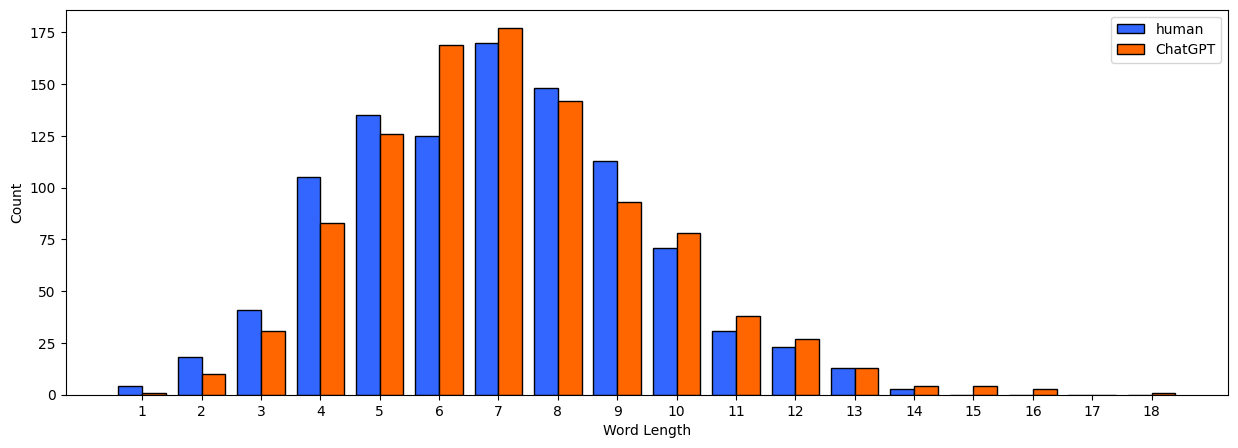

& \textbf{4} & \textbf{18} & \textbf{41} & \textbf{105} & \textbf{135} & 125 & 170 & \textbf{148} & \textbf{113} & 71 & 31 & 23 & 13 & 3 & 0 & 0 & 0 & 0 
& 1 & 10 & 31 & 83 & 126 & \textbf{169} & \textbf{177} & 142 & 93 & \textbf{78} & \textbf{38} & \textbf{27} & 13 & \textbf{4} & \textbf{4} & \textbf{3} & 0 & \textbf{1} 

In [51]:
# Analysis 1: Word length

# Count length of top contribution words for human and ChatGPT
lens = np.zeros((2, 100))
maxlen = [0, 0]
for i in [0,1]:
    for word in words[i]:
        if word[0].isalpha() == False:
            print(word)
            continue  # Ignore non-words
        nowlen = len(word)
        lens[i][nowlen] += 1
        if nowlen > maxlen[i]: maxlen[i] = nowlen

# Plot the results
import matplotlib.pyplot as plt
maxx = max(maxlen[0], maxlen[1])
fig,ax=plt.subplots(figsize=(15, 5))
x = np.arange(1, maxx+1)
width=0.4
ax.bar(x, lens[0][1:maxx+1], width, color="#3366FF", label="human", edgecolor="black")
ax.bar(x+width, lens[1][1:maxx+1], width, color="#FF6600", label="ChatGPT", edgecolor="black")
ax.set_xticks(x+width/2)
plt.legend()
ax.set_xlabel("Word Length")
ax.set_ylabel("Count")
ax.set_xticklabels(x)
plt.show();

for i in range(1, maxx+1):
    if lens[0][i] > lens[1][i]:
        print("& \\textbf{"+str(int(lens[0][i]))+"} ", end="")
    else:
        print("& "+str(int(lens[0][i]))+" ", end="")
print()
for i in range(1, maxx+1):
    if lens[0][i] < lens[1][i]:
        print("& \\textbf{"+str(int(lens[1][i]))+"} ", end="")
    else:
        print("& "+str(int(lens[1][i]))+" ", end="")

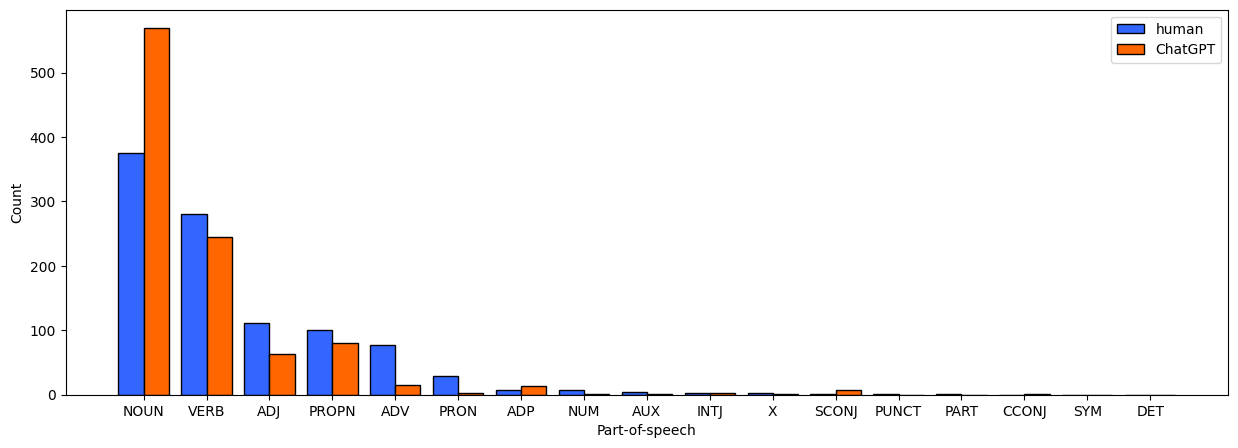

& NOUN & VERB & ADJ & PROPN & ADV & PRON & ADP & NUM & AUX & INTJ & X & SCONJ & PUNCT & PART & CCONJ & SYM & DET 
& 375 & \textbf{281} & \textbf{111} & \textbf{100} & \textbf{77} & \textbf{29} & 7 & \textbf{7} & \textbf{5} & \textbf{3} & \textbf{2} & 1 & \textbf{1} & \textbf{1} & 0 & 0 & 0 
& \textbf{569} & 244 & 63 & 80 & 15 & 3 & \textbf{13} & 1 & 1 & 2 & 1 & \textbf{7} & 0 & 0 & \textbf{1} & 0 & 0 

In [52]:
# Analysis 2: Part-of-speech

# Count different POS of top contribution words
import spacy
posModel = spacy.load('en_core_web_sm')  # Load the POS dictionary
POSlist = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON',
           'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']
POS = np.zeros((2, 20))
for i in [0,1]:
    for word in words[i]:
        pos = posModel(word)[0].pos_
        POS[i][POSlist.index(pos)] += 1

# Plot the results
import matplotlib.pyplot as plt
y0, y1, xlabel = (list(t) for t in zip(*sorted(zip(list(POS[0][:len(POSlist)]), list(POS[1][:len(POSlist)]), POSlist), reverse=True)))
fig, ax=plt.subplots(figsize=(15, 5))
x = np.arange(len(POSlist))
width=0.4
ax.bar(x, y0, width, color="#3366FF", label="human", edgecolor="black")
ax.bar(x+width, y1, width, color="#FF6600", label="ChatGPT", edgecolor="black")
ax.set_xticks(x+width/2)
plt.legend()
ax.set_xlabel("Part-of-speech")
ax.set_ylabel("Count")
ax.set_xticklabels(xlabel)
plt.show();

for i in range(len(POSlist)):
    print("& "+xlabel[i]+" ", end="")
print()
for i in range(len(POSlist)):
    if y0[i] > y1[i]:
        print("& \\textbf{"+str(int(y0[i]))+"} ", end="")
    else:
        print("& "+str(int(y0[i]))+" ", end="")
print()
for i in range(len(POSlist)):
    if y0[i] < y1[i]:
        print("& \\textbf{"+str(int(y1[i]))+"} ", end="")
    else:
        print("& "+str(int(y1[i]))+" ", end="")

In [24]:
# Analysis 3: Sentiment

# Load the dictionary of word sentiment
import pandas as pd
df = pd.read_table("SentiWordNet_3.0.0.txt")
df = df.drop(columns=["Gloss", "POS", "ID"])
df = df[["SynsetTerms", "PosScore", "NegScore"]]
df["ObjScore"] = round(1 - df["PosScore"] - df["NegScore"], 3)  # Calculate the objectivity score

# Create a dictionary to record objectivity score for each word
objScore = {}
for i in df.index:
    wordss = df["SynsetTerms"][i].strip().split(" ")
    score = df["ObjScore"][i]
    for word in wordss:
        objScore[word.split("#")[0]] = score

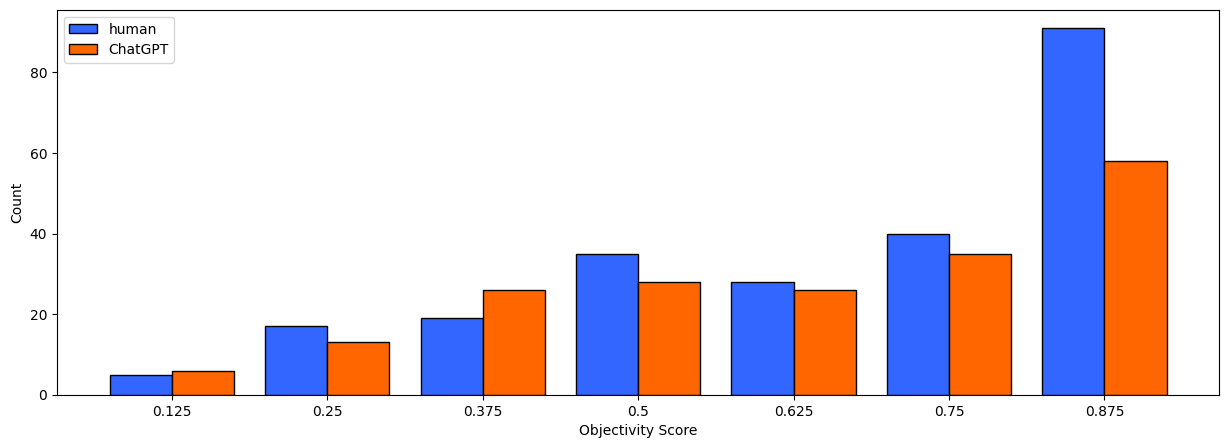

& 5 & \textbf{17} & 19 & \textbf{35} & \textbf{28} & \textbf{40} & \textbf{91} 
& \textbf{6} & 13 & \textbf{26} & 28 & 26 & 35 & 58 

In [43]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

# Transfer the POS symbols from nltk to WordNet
def get_pos(tag):
    if   tag[0] == "J": return wordnet.ADJ
    elif tag[0] == "V": return wordnet.VERB
    elif tag[0] == "N": return wordnet.NOUN
    elif tag[0] == "R": return wordnet.ADV
    else:               return None

# Count objectivity for top contribution words
wnl = WordNetLemmatizer()  # Load Lemmatizer model
objLevels = [0.000, 0.125, 0.250, 0.375, 0.500, 0.625, 0.750, 0.875, 1.000]
obj = np.zeros((2, 9))
# Set = [set(), set()]
for i in [0,1]:
    for word in words[i]:
        # if word.lower() in Set[i]: continue  # Ignore repeated words
        # Set[i].add(word.lower())
        pos = get_pos(pos_tag([word.lower()])[0][1])  # Get the POS for lemmatizing
        if pos is None: origin = wnl.lemmatize(word.lower())
        else: origin = wnl.lemmatize(word.lower(), pos)
        score = objScore.get(origin, -1)
        if score == -1: continue  # Ignore non-recorded word
        obj[i][objLevels.index(score)] += 1

# Plot the results
import matplotlib.pyplot as plt
fig, ax=plt.subplots(figsize=(15, 5))
x = np.arange(1,8)
width=0.4
ax.bar(x, obj[0][1:8], width, color="#3366FF", label="human", edgecolor="black")
ax.bar(x+width, obj[1][1:8], width, color="#FF6600", label="ChatGPT", edgecolor="black")
ax.set_xticks(x+width/2)
plt.legend()
ax.set_xlabel("Objectivity Score")
ax.set_ylabel("Count")
ax.set_xticklabels(objLevels[1:8])
plt.show();

for i in range(1,8):
    if obj[0][i] > obj[1][i]:
        print("& \\textbf{"+str(int(obj[0][i]))+"} ", end="")
    else:
        print("& "+str(int(obj[0][i]))+" ", end="")
print()
for i in range(1,8):
    if obj[0][i] < obj[1][i]:
        print("& \\textbf{"+str(int(obj[1][i]))+"} ", end="")
    else:
        print("& "+str(int(obj[1][i]))+" ", end="")